# Desbalanceo y Reducción de Instancias

## Reducción de Instancias (*Under-Sampling*)

A menudo los datos contienen instancias redundantes. Como el tamaño puede
afectar a la calidad de los resultados (y el tiempo) vamos a intentar reducirlo.

También es importante cuando las muestras están poco balanceadas.

Veremos dos enfoques: generación de prototipos, y selección de prototipos.

Usaremos en este apartado el estupendo paquete `imblearn`, documentado en
[https://imbalanced-learn.org/stable/](https://imbalanced-learn.org/stable/)

## Generación de Prototipos

En este caso se reducen las muestras pero las que quedan son generadas (no
seleccionadas) del original. La técnica más usada es el **K-Means**, y
sintetizar cada clase con un centroide del **K-Means** en vez de uar las
muestras originales.


Vamos a crear unos datos de ejemplo:

In [41]:
from sklearn.datasets import make_classification
from collections import Counter
#Create an artificial datasets to see the effects of under-sampling and over-sampling
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=10)

print(sorted(Counter(y).items()))

[(0, 67), (1, 264), (2, 4669)]


Están poco balanceadas.


Visualizamos los puntos:

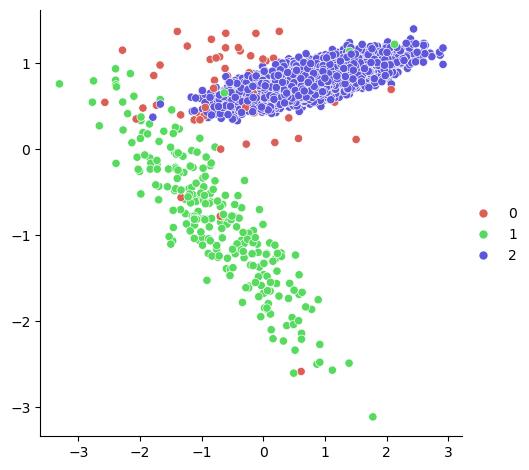

In [42]:
import seaborn as sns
from matplotlib import pyplot as plt

palette = sns.color_palette("hls", 3)

sns.reset_defaults()
sns.relplot(x=X[:,0], y=X[:,1], hue=y, palette=palette)
plt.show()

Aplicamos el *under_sampling*:

In [43]:
from imblearn.under_sampling import ClusterCentroids

#Perform clustering-based prototype generation
cc = ClusterCentroids(random_state=0, voting="soft")
X_resampled, y_resampled = cc.fit_resample(X, y)

print(sorted(Counter(y_resampled).items()))
reduced = (X.shape[0]-X_resampled.shape[0])/X.shape[0]
print(f"Reduce el {100*reduced} %")

[(0, 67), (1, 67), (2, 67)]
Reduce el 95.98 %


c:\Users\julian\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Ahora cada clase está balanceada.


Visualizamos la salida:

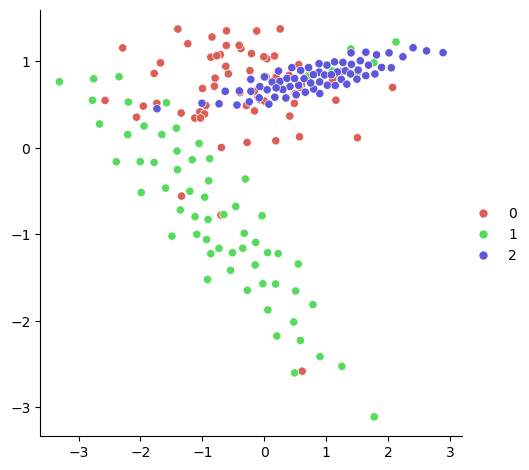

In [44]:
sns.relplot(x=X_resampled[:,0], y=X_resampled[:,1], hue=y_resampled, palette=palette)
plt.show()

## Generación de prototipos mediante clustering (GLVQ)

Vamos a implementar una técnica clásica de generación de prototipos (https://proceedings.neurips.cc/paper/1995/file/9c3b1830513cc3b8fc4b76635d32e692-Paper.pdf)

Para entender el Generalized Learning Vector Quantization (GLVQ), el conjunto de prototipos se ha considerado como $W = w_1, \dots, w_l$ para cada clase en el conjunto de datos donde $l \in \{1, \dots, L\}$ y $L$ es el conjunto de etiquetas de clase. Para la comparación de muestras entre los prototipos, se ha representado una matriz de distancias por $D_{(i,j)} = d(v_i,w_j)$ donde $d$ es una medida de disimilitud diferenciable. Además de esto, una función de clasificador (diferencia de distancia relativa) para GLVQ se define como:

![GLVQ](GLVQ.png)

donde $w^+$ es el prototipo correcto que mejor coincide con $c(w^+) = c(v)$ y $w^-$ es el prototipo más cercano que pertenece a la clase incorrecta $c(w^+) \neq c(v)$. Para una clasificación correcta, la distancia $d(v, w^+)$ del punto de datos que pertenece al prototipo de clase correcta debería ser menor que la distancia $d(v, w^-)$ del prototipo que pertenece a la clase incorrecta. En este caso, la salida de la función del clasificador son valores negativos y, por lo tanto, la función de costo de $E$ GLVQ es entonces una aproximación del error de clasificación global.

Instalar:

In [45]:
!pip install sklvq

In [46]:
from sklvq import GLVQ

glvq = GLVQ(
    distance_type="squared-euclidean",
    activation_type="swish",
    activation_params={"beta": 2},
    solver_type="steepest-gradient-descent",
    solver_params={"max_runs": 20, "step_size": 0.1},
)

# ajustamos el modelo para que aprenda los prototipos
glvq.fit(X, y)

GLVQ(activation_params={'beta': 2}, activation_type='swish',
     solver_params={'max_runs': 20, 'step_size': 0.1})

Vamos a extraer los prototipos y dibujarlos

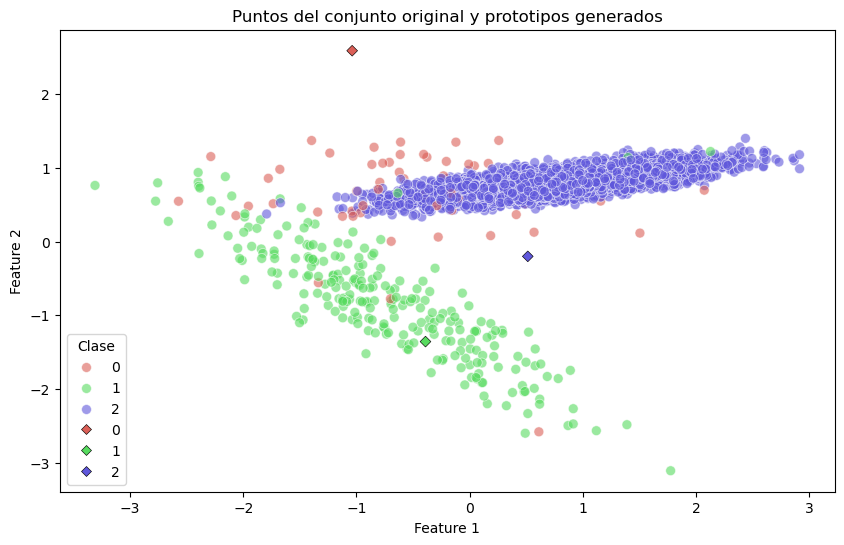

In [47]:
# Obtener los prototipos generados por el modelo GLVQ
prototypes = glvq.prototypes_

# Crear el gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=palette, alpha=0.6, s=50)
sns.scatterplot(x=prototypes[:, 0], y=prototypes[:, 1], hue=[0, 1, 2], palette=palette, marker='D', s=30, edgecolor='black')

plt.title('Puntos del conjunto original y prototipos generados')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Clase')
plt.show()

Podemos utilizar los prototipos para aprender un modelo con el que clasificar o utilizar KNN para las distancias.

Vamos a utilizar KNN para predecir sobre el conjunto completo (habría que usar algún esquema de validación...) con el método *predict* incorporado.

In [48]:
from sklearn.metrics import classification_report

predicted_y = glvq.predict(X)

print(classification_report(y, predicted_y))

              precision    recall  f1-score   support

           0       0.57      0.25      0.35        67
           1       0.98      0.88      0.92       264
           2       0.99      1.00      0.99      4669

    accuracy                           0.98      5000
   macro avg       0.84      0.71      0.76      5000
weighted avg       0.98      0.98      0.98      5000



En el atributo *prototypes_* encontramos los prototipos generados, que se pueden usar en el método *fit()* de algún método de *sklearn*.

In [49]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(glvq.prototypes_,glvq.prototypes_labels_) #Ajustamos el modelo con los prototipos generados por GLVQ

predicted_y = knn.predict(X) #Predecimos las etiquetas de los datos originales
print(classification_report(y, predicted_y))

              precision    recall  f1-score   support

           0       0.57      0.25      0.35        67
           1       0.98      0.88      0.92       264
           2       0.99      1.00      0.99      4669

    accuracy                           0.98      5000
   macro avg       0.84      0.71      0.76      5000
weighted avg       0.98      0.98      0.98      5000



Vemos que los resultados coinciden con los del método nativo de sklvq.

Vamos a probar ajustando un Decision tree y comparamos el rendimiento al entrenar con el conjunto completo.

In [50]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt_orig = DecisionTreeClassifier()
dt.fit(glvq.prototypes_,glvq.prototypes_labels_) #Ajustamos el modelo con los prototipos generados por GLVQ
dt_orig.fit(X,y)

predicted_y = dt.predict(X) #Predecimos las etiquetas de los datos originales
predicted_y_orig = dt_orig.predict(X) #Predecimos las etiquetas de los datos originales
#Comparamos los resultados
print(classification_report(y, predicted_y))
print(classification_report(y, predicted_y_orig))

              precision    recall  f1-score   support

           0       0.11      0.33      0.17        67
           1       0.11      0.25      0.15       264
           2       0.98      0.88      0.93      4669

    accuracy                           0.84      5000
   macro avg       0.40      0.49      0.42      5000
weighted avg       0.92      0.84      0.88      5000

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       1.00      1.00      1.00       264
           2       1.00      1.00      1.00      4669

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



Existe otra biblioteca compatible con *scikit-learn* que tiene algunos modelos más: https://sklearn-lvq.readthedocs.io/en/stable/index.html

El repositorio está en https://github.com/MrNuggelz/sklearn-lvq y se instala con:

In [51]:
#!pip install sklearn-lvq

## Selección de prototipos

En este enfoque se muestrean menos instancias pero las que quedan son instancias
del conjunto original.

En `imblearn` hay muchos, escogeremos dos:

- Aleatorio: *Random under sampling technique*, una técnica rápida muestreando
  aleatoriamente para cada clase.
- Usando vecindario: *Edited nearest neighbours*, usa el vecindario para
  eliminar instancias demasiado alejadas del vecindario.

## *Random under sampling technique*

In [52]:
from imblearn.under_sampling import RandomUnderSampler

#Perform random prototype selection
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))
reduced = (X.shape[0]-X_resampled.shape[0])/X.shape[0]
print(f"Reduce el {100*reduced:.2} %")

[(0, 67), (1, 67), (2, 67)]
Reduce el 9.6e+01 %


Vamos a mostrarlo:

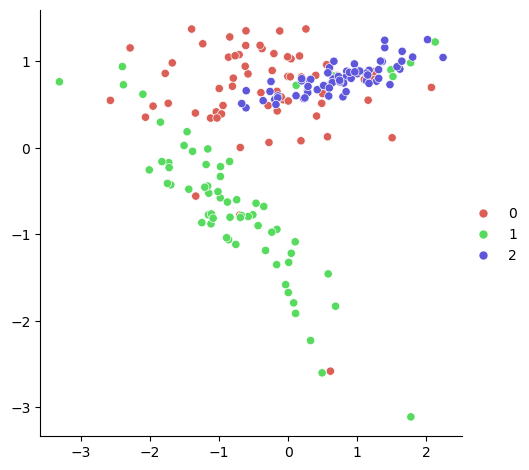

In [53]:
sns.relplot(x=X_resampled[:,0], y=X_resampled[:,1], hue=y_resampled, palette=palette)
plt.show()

## *Edited Nearest Neighbours*

*Edited Nearest Neighbours* aplica el algoritmo de vecinos más cercanos y
*borra* las instancias que no son *suficientemente* similares a las del
vecindario.

Para cada instancia, se calculas sus vecinas y si no se cumple el criterio se
borra.

Existen dos criterio a la hora de comparar las vecindas:

- La mayoría (`kind_sel='mode'`) deben pertenecer a la misma clase.

- Que todas (`kind_sel='all'`) pertenezcan a la misma clase.

El primero es más conservador y el segundo excluye más.


Aplicamos primero el más conservador:

In [54]:
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours(kind_sel="all")
X_resampled, y_resampled = enn.fit_resample(X, y)
print(X_resampled.shape)
print(sorted(Counter(y_resampled).items()))
reduced = (X.shape[0]-X_resampled.shape[0])/X.shape[0]
print(f"Reduce el {100*reduced:.2} %")

(4824, 2)
[(0, 67), (1, 223), (2, 4534)]
Reduce el 3.5 %


Visualizamos:

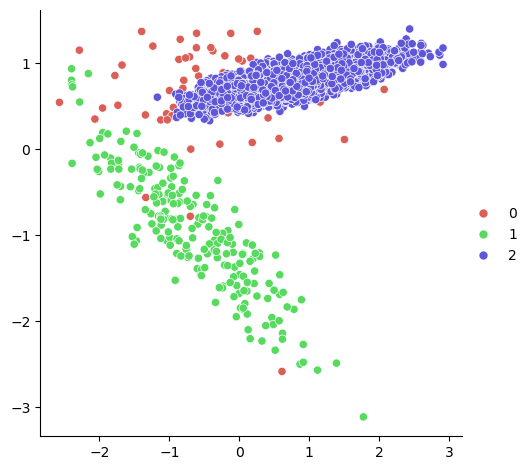

In [55]:
sns.relplot(x=X_resampled[:,0], y=X_resampled[:,1], hue=y_resampled, palette=palette)
plt.show()

Aplicamos el menos conservador:

In [56]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours(kind_sel="mode")
X_resampled, y_resampled = enn.fit_resample(X, y)

print(X_resampled.shape)
print(sorted(Counter(y_resampled).items()))
reduced = (X.shape[0]-X_resampled.shape[0])/X.shape[0]
print(f"Reduce el {100*reduced:.2} %")

(4972, 2)
[(0, 67), (1, 244), (2, 4661)]
Reduce el 0.56 %


Visualizamos:

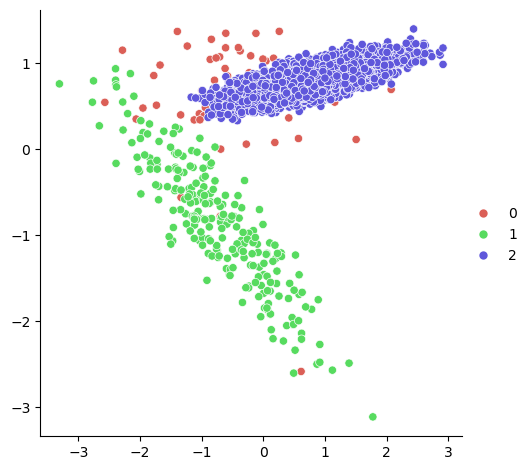

In [57]:
sns.relplot(x=X_resampled[:,0], y=X_resampled[:,1], hue=y_resampled, palette=palette)
plt.show()

## *Condensed Nearest Neighbours*

Intenta añadir al conjunto de entrenamiento reducido aquellas instancias conflictivas que sean necesarias para obtener una buena frontera de decisión. Por tanto, debería generar un conjunto más reducido que ENN.

In [58]:
from imblearn.under_sampling import CondensedNearestNeighbour  
cnn = CondensedNearestNeighbour()
X_resampled, y_resampled = cnn.fit_resample(X, y)
print(X_resampled.shape)
print(sorted(Counter(y_resampled).items()))
reduced = (X.shape[0]-X_resampled.shape[0])/X.shape[0]
print(f"Reduce el {100*reduced:.2} %")

(275, 2)
[(0, 67), (1, 39), (2, 169)]
Reduce el 9.4e+01 %


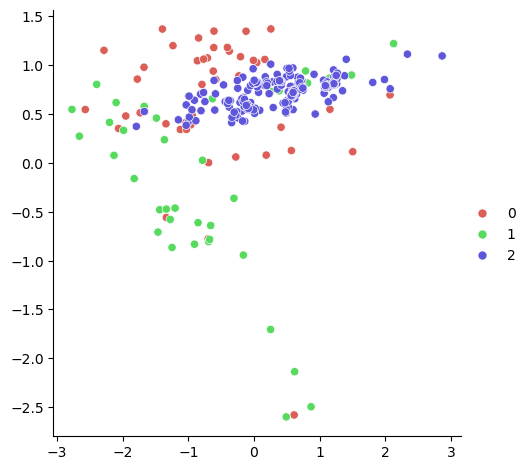

In [59]:
sns.relplot(x=X_resampled[:,0], y=X_resampled[:,1], hue=y_resampled, palette=palette)
plt.show()

## *AllKNN*

Aplica ENN variando el valor de *k*, por lo que es más efectivo pero también consume más recursos (tiempo y memoria).
Con el parámetro *n_neighbors* controlamos el máximo valor de *k* que se probará.

In [60]:
from imblearn.under_sampling import AllKNN  
allknn = AllKNN(n_neighbors = 10)
X_resampled, y_resampled = allknn.fit_resample(X, y)
print(X_resampled.shape)
print(sorted(Counter(y_resampled).items()))
reduced = (X.shape[0]-X_resampled.shape[0])/X.shape[0]
print(f"Reduce el {100*reduced:.2} %")

(4532, 2)
[(0, 67), (1, 168), (2, 4297)]
Reduce el 9.4 %


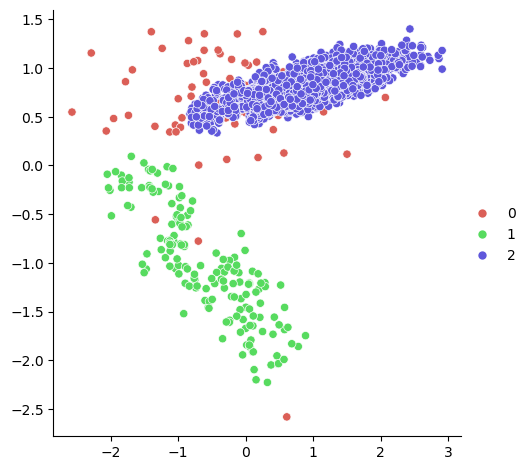

In [61]:
sns.relplot(x=X_resampled[:,0], y=X_resampled[:,1], hue=y_resampled, palette=palette)
plt.show()

## Sobre Muestreo

Aunque no es reducción vamos a ver cómo se pueden sobre-muestrear las instancias
para tener más ejemplares de las clases minoritarias y obtener mejor resultados.

`imblearn` ofrece varios, como el aleatorio, **SMOTE**, entre otros. Vamos a ver
los dos primeros.


Primero creamos los datos

In [62]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=42)

print(sorted(Counter(y).items()))

[(0, 5), (1, 27), (2, 468)]


Vamos a visualizar el original:

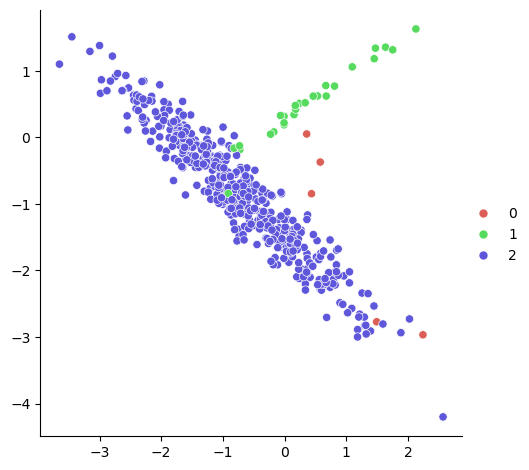

In [63]:
sns.relplot(x=X[:,0], y=X[:,1], hue=y, palette=palette)
plt.show()

## RandomOverSampler

Ahora aplicamos el RandomOverSampler

In [64]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X, y)

print(X_resampled.shape)
print(sorted(Counter(y_resampled_ros).items()))

(4532, 2)
[(0, 468), (1, 468), (2, 468)]


Vamos a aplicarlo:

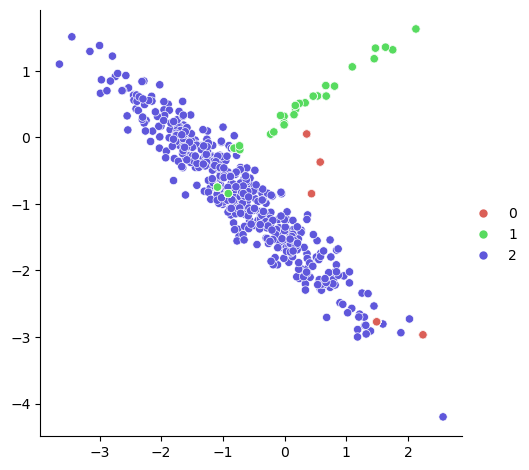

In [65]:
sns.relplot(x=X_resampled_ros[:,0], y=X_resampled_ros[:,1], hue=y_resampled_ros, palette=palette)
plt.show()

## SMOTE

Otra técnica clásica es **SMOTE**, que genera datos de forma sintética.

In [66]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)
print(X_resampled.shape)
print(sorted(Counter(y_resampled_smote).items()))

(4532, 2)
[(0, 468), (1, 468), (2, 468)]


Vamos a aplicarlo:

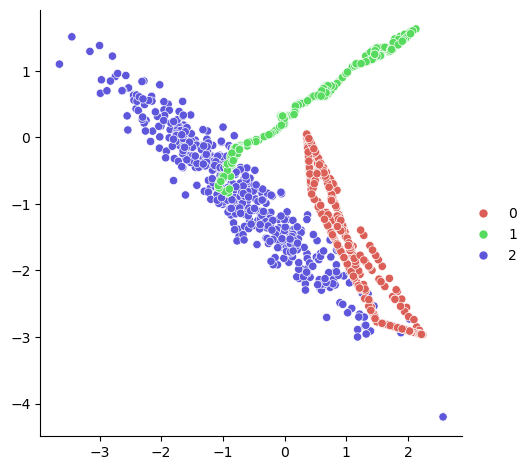

In [67]:
sns.relplot(x=X_resampled_smote[:,0], y=X_resampled_smote[:,1], hue=y_resampled_smote, palette=palette)
plt.show()

## Ejercicios

1. Haz un Edited Nearest Neighbours sobre el original usando una estrategia de voto menos conservadora,
   ¿cuántos ha quitado?

2. Aplica otras técnicas de selección de instancias al conjunto y compara los porcentajes de reducción. Considera las técnicas de creación de prototipos también.

3. Aplica algún clasificador a las diferentes reducciones creadas (usa algún esquema de validación). ¿El rendimiento en test tiene alguna relación con el porcentaje de reducción obtenido por las técnicas?

4. *Avanzado* Usando el *KFold* de sklearn, intenta replicar alguna selección de instancia estratificada (por ejemplo con ENN) y compara los resultados con el algoritmo sobre el conjunto de entrenamiento completo.
   
5. Students no está bien balanceado. Prueba las diferentes técnicas de sobre/bajo-muestreo sobre el mismo y aplica un clasificador. Usa alguna métrica sensible al desbalanceo (F1, AUC, etc.) o la matriz de confusión para observar si los resultados de la clase minoritaria mejoran.

6. *Avanzado* Combina técnicas de sobre-muestreo con técnicas de selección de instancias o ruido para intentar mejorar los resultaods del punto 5 (https://imbalanced-learn.org/stable/references/combine.html).

7. *Avanzado+* Combina alguna técnica de selección de instancias con alguna de selección de características. ¿Hay algún orden que de mejores resultados (1º SI o 1º SC??)


In [68]:
import pandas as pd

students = pd.read_csv("estudiantes.csv")